In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from glob import glob

In [3]:
import lanelines
import roadplane

from compgraph import CompGraph, CompGraphRunner
import nxpd
nxpd.nxpdParams['show'] = 'ipynb'

## Initialization

In [4]:
test_images = [lanelines.open_image(f) for f in glob('test_images/*.jpg')]

In [5]:
CANVAS_SZ = (600, 800)

warp_src = np.load('serialize/planepoints.npy')
warp_dst = lanelines.get_rectangle_corners_in_image(CANVAS_SZ, offset_x=100, offset_y=20)

M = cv2.getPerspectiveTransform(warp_src, warp_dst)
Minv = cv2.getPerspectiveTransform(warp_dst, warp_src)

In [6]:
warped_images = [cv2.warpPerspective(im, M, CANVAS_SZ, flags=cv2.INTER_LINEAR) for im in test_images]

## Functions

In [7]:
def convert_to_HLS(im):
    return cv2.cvtColor(im, cv2.COLOR_RGB2HLS)


def weighted_sum_images(images, weights):
    
    assert len(weights) == len(images)
    
    nonzero_indices = np.nonzero(weights)[0]
    if len(nonzero_indices) < 2:
        raise Exception('At least 2 non-zero weights are required')
    
    first, second = nonzero_indices[:2]
    res = cv2.addWeighted(images[first], weights[first], images[second], weights[second], 0)
    
    if len(nonzero_indices) == 2:
        return res
    
    for i in nonzero_indices[2:]:
        res = cv2.addWeighted(res, 1., images[i], weights[i], 0)
        
    return res


def bitwise_or(images):
    
    assert len(images) > 0
    
    if len(images) == 1:
        return images[0]
    
    res = cv2.bitwise_or(images[0], images[1])
    if len(images) == 2:
        return res
    
    for im in images[2:]:
        res = cv2.bitwise_or(res, im)
        
    return res
    
    
def weighted_HLS(H, L, S, weights):
    return weighted_sum_images([H, L, S], weights)


def add_contrast(im, gain):
    gained = gain * im
    return lanelines.scale_image_255(gained)


def sobel_combo(im):
    
    sobelx = lanelines.sobel_x(im)
    sobely = lanelines.sobel_y(im)
    
    magnitude = lanelines.sobel_magnitude(sobelx, sobely)
    direction = lanelines.sobel_direction(sobelx, sobely)
    
    return lanelines.scale_image_255(magnitude), lanelines.scale_image_255(direction)


def scaled_sobel_x(im):
    return lanelines.scale_image_255( lanelines.sobel_x(im) )


def morphological_close(im, kernel=(3, 3)):
    return cv2.morphologyEx(im, cv2.MORPH_CLOSE, kernel)


def get_hls_channels(im):
    
    hls = convert_to_HLS(im)
    
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    
    return H, L, S

def gather_thresholded_images(*images):
    return images
    

## Pipeline

In [8]:
func_dict = {
    'get_HLS': get_hls_channels,
    'weighted_HLS_sum': weighted_HLS,
    'threshold_S': lanelines.mask_threashold_range,
    'threshold_H': lanelines.mask_threashold_range,
    'threshold_wHLS': lanelines.mask_threashold_range,
    'apply_sobel_x_to_S': scaled_sobel_x,
    'threshold_S_sobel_x': lanelines.mask_threashold_range,
    'median_blur_tssx': cv2.medianBlur,
    'close_thresholded_S': morphological_close,
    'gather_thresholded_images': gather_thresholded_images,
    'combine_thresholds_weighted': weighted_sum_images,
    
}

func_io = {
    'get_HLS': ('image', ('H', 'L', 'S')),
    'weighted_HLS_sum': (('H', 'L', 'S', 'HLS_weights'), 'weighted_HLS'),
    'threshold_S': (('S', 'S_from', 'S_to'), 'thresholded_S'),
    'threshold_H': (('H', 'H_from', 'H_to'), 'thresholded_H'),
    'threshold_wHLS': (('weighted_HLS', 'wHLS_from', 'wHLS_to'), 'thresholded_wHLS'),
    'apply_sobel_x_to_S': ('S', 'S_sobel_x'),
    'threshold_S_sobel_x': (('S_sobel_x', 'S_sobel_x_from', 'S_sobel_x_to'), 'thresholded_S_sobel_x'),
    'median_blur_tssx': (('thresholded_S_sobel_x', 'tssx_median_kernel'), 'tssx_median'),
    'close_thresholded_S': (('thresholded_S', 'close_kernel_for_tS'), 'ts_closed'),
    'gather_thresholded_images': (
        ('ts_closed', 'thresholded_S_sobel_x', 'thresholded_S', 'thresholded_wHLS'), # 'tssx_median', 'ts_closed', 'thresholded_H'
        'thresholded_images'
    ),
    'combine_thresholds_weighted': (('thresholded_images', 'thresholded_images_weights'), 'mega_image'),
}

cg = CompGraph(func_dict, func_io)

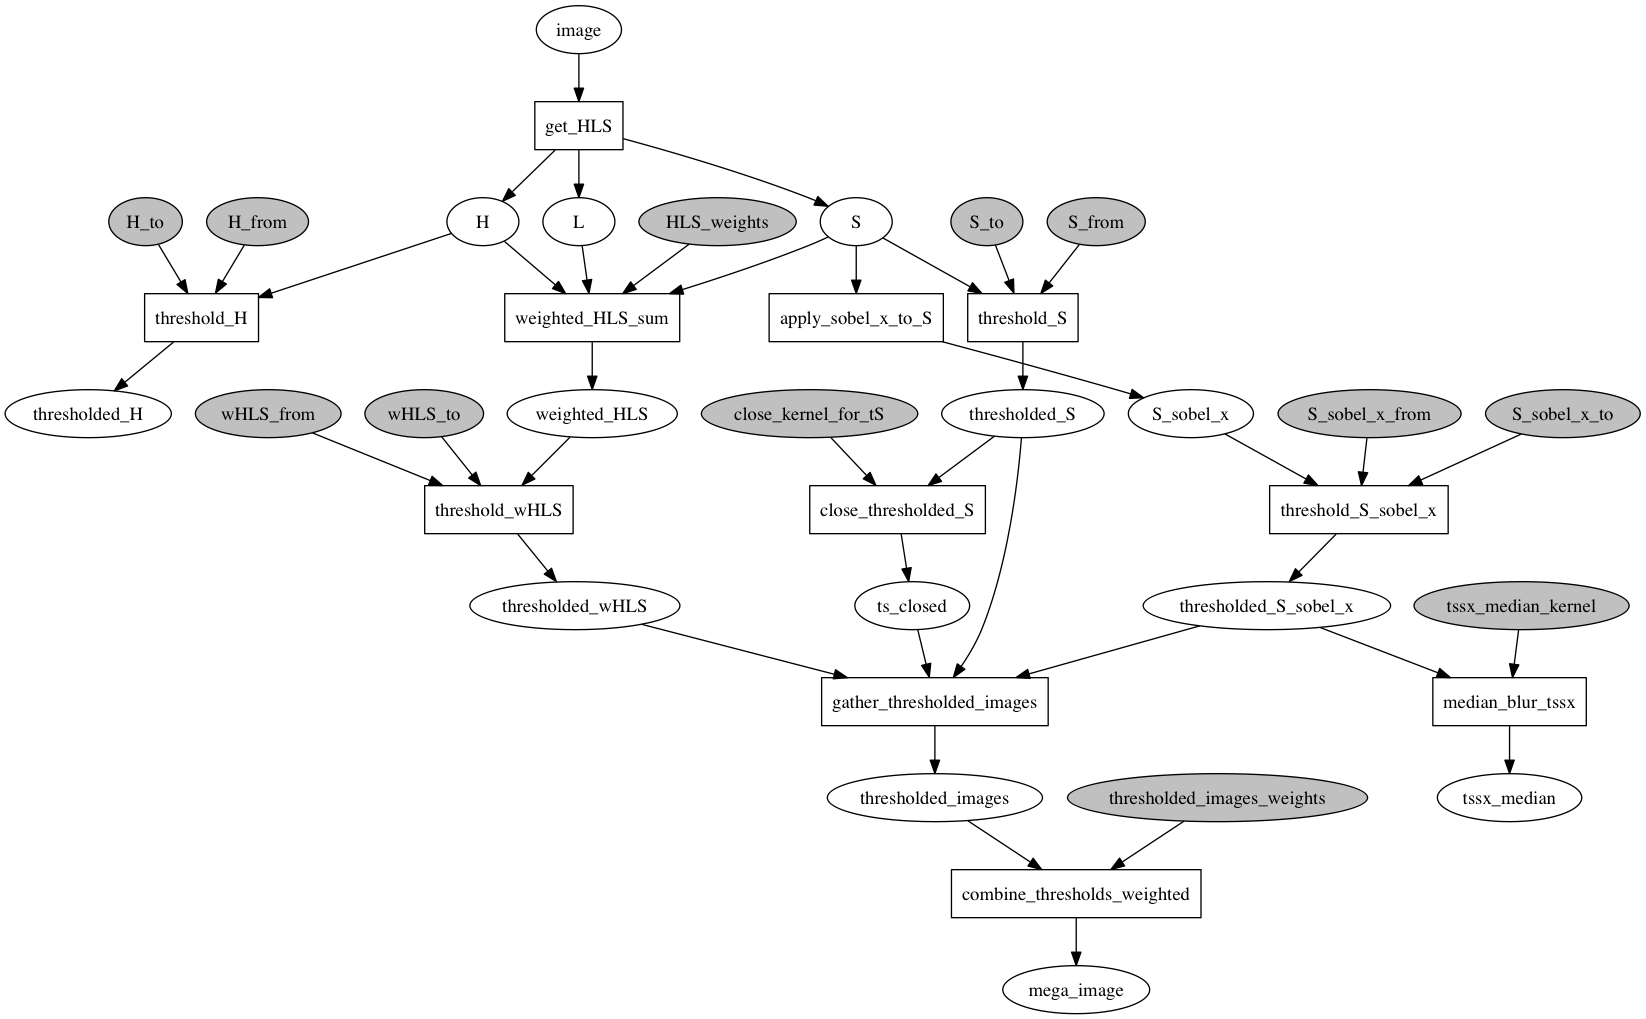

In [9]:
params = {
    'HLS_weights': [0, 0.4, 1.],   # [0, 0.7, 1.],
    'S_from': 180, # 180
    'S_to': 250,
    'H_from': 95,
    'H_to': 100,
    'wHLS_from': 180,   # 220
    'wHLS_to': 255,     # 250
    'S_sobel_x_from': 20, # 20
    'S_sobel_x_to': 100, #60
    'tssx_median_kernel': 5,
    'close_kernel_for_tS': (3, 3),
    'thresholded_images_weights': [
        #'ts_closed', 'thresholded_S_sobel_x', 'thresholded_S', 'thresholded_wHLS'
        1.,
        1.,
        0.9,
        0.8
    ]
}

runner = CompGraphRunner(cg, frozen_tokens=params)
runner.run(image=warped_images[1])

nxpd.draw(runner.token_manager.to_networkx())

## Experiments

In [10]:
def show_intermediate_images(im, runner):
    
    tokens = (
        'thresholded_S', 
        'thresholded_H', 
        'weighted_HLS', 
        'thresholded_wHLS', 
        'thresholded_S_sobel_x', 
        'tssx_median', 
        'ts_closed'
    )
    
    runner.run(image=im)
    
    plt.figure(figsize=(20, 5))
    
    for i, tk in enumerate(tokens):
        plt.subplot(1, len(tokens), i+1)
        plt.imshow( runner[tk] )
        _ = plt.axis('off')
        plt.title(tk)



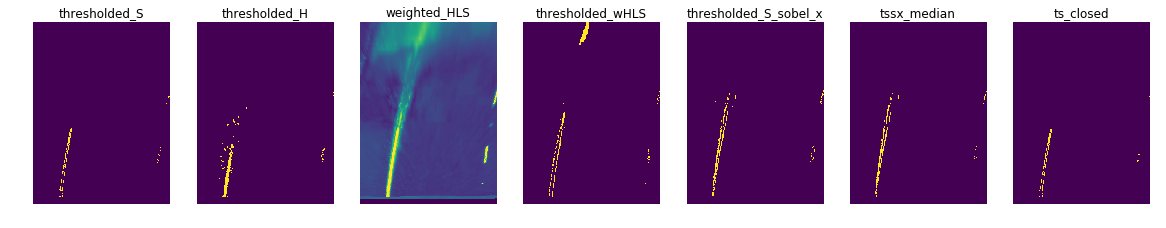

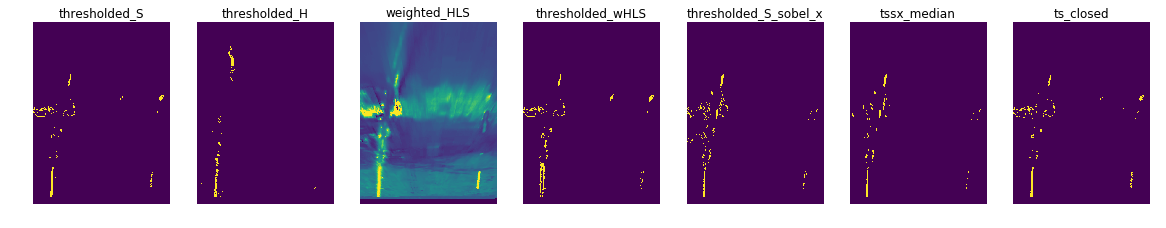

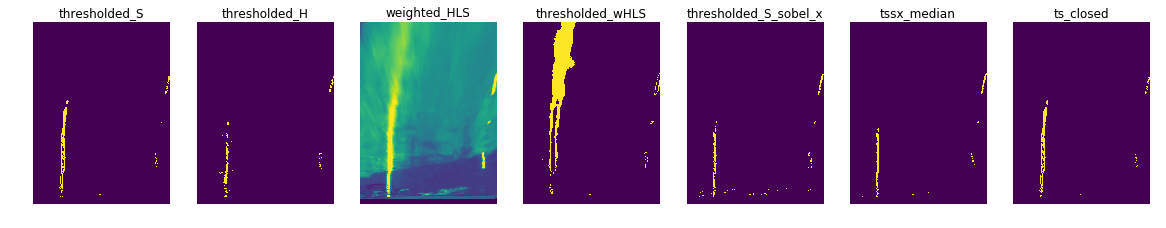

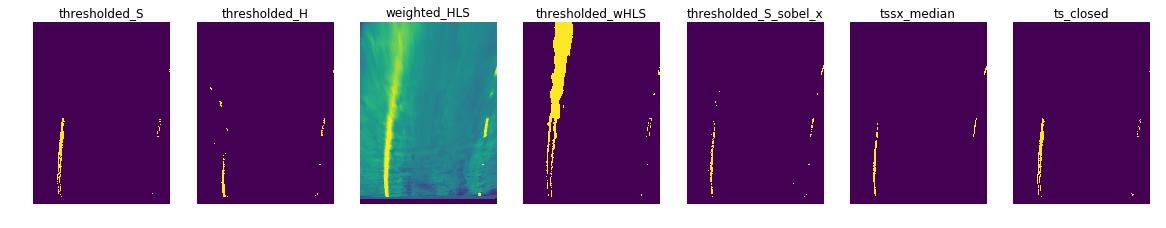

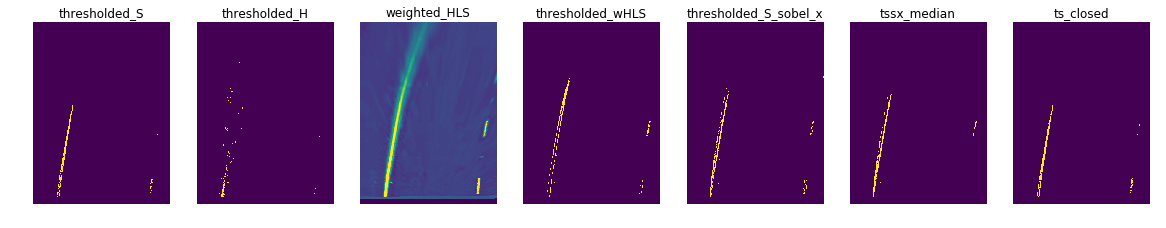

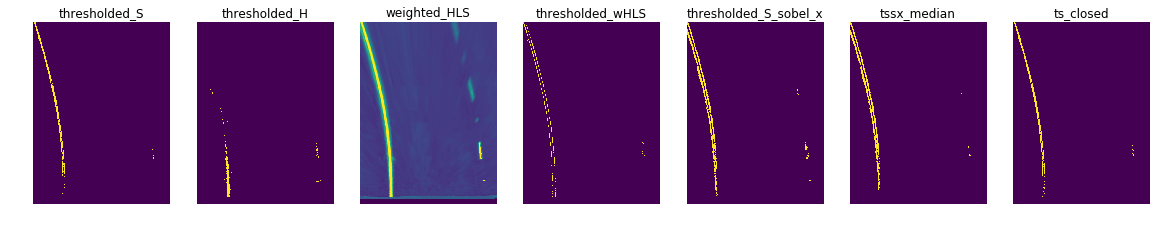

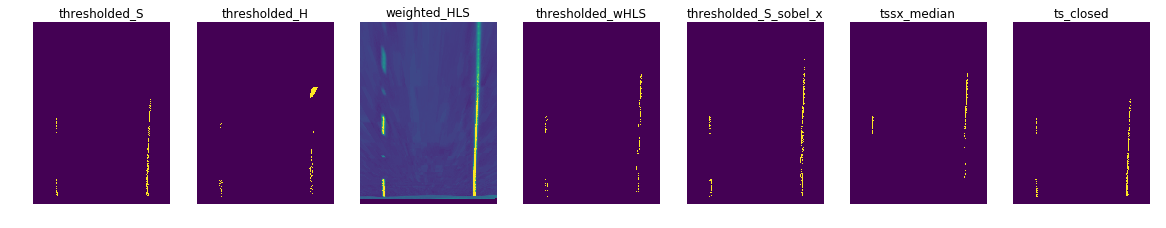

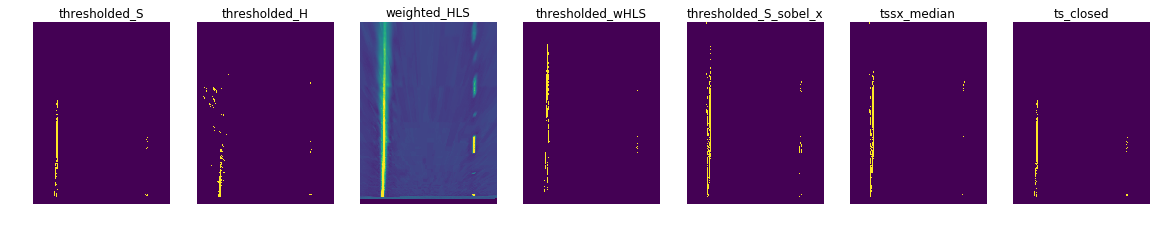

In [11]:
for im in warped_images:
    show_intermediate_images(im, runner)

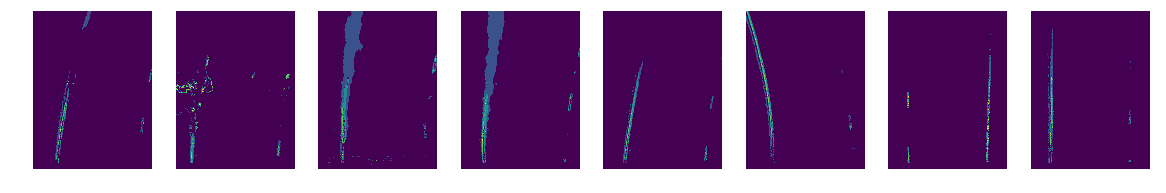

In [12]:
plt.figure(figsize=(20, 5))

for i, im in enumerate(warped_images):
    runner.run(image=im)
    
    plt.subplot(1, 8, i+1)
    plt.imshow( runner['mega_image'])
    _ = plt.axis('off')

In [13]:
def lane_cells(im, nx, ny, threshold=20):
    
    cells = divide_image_to_cells(im, nx, ny)
    
    res = []
    
    for i in range(ny):
        
        idx_from = i * nx
        idx_to = i * nx + nx
        
        rowcells = cells[idx_from:idx_to]
        
        sums = np.array([np.sum(cell) for cell in rowcells])
        max_j = np.argmax(sums)
        
        if sums[max_j] > threshold:
            res.append( (i, max_j) ) 
        
    return np.array(res)


def lane_cells_real_coords(lanecells, im, nx, ny):
    
    rows, cols= im.shape[:2]
    
    cell_sz_x = cols // nx
    cell_sz_y = rows // ny
    
    points = np.zeros_like(lanecells)
    
    for i in range(len(lanecells)):
        idx_row, idx_col = lanecells[i, :]
        x = idx_col * cell_sz_x + cell_sz_x / 2
        y = idx_row * cell_sz_y + cell_sz_y / 2
        points[i, :] = (x, y)
        
    return points
    
        

def divide_image_to_cells(im, nx, ny):
    
    rows, cols= im.shape[:2]
    
    assert rows % ny == 0
    assert cols % nx == 0
    
    offset_x = cols // nx
    offset_y = rows // ny
    
    cells = []
    
    for j in range(ny):
        for i in range(nx):
            
            x_from = i * offset_x
            x_to = x_from + offset_x 
            y_from = j * offset_y
            y_to = y_from + offset_y

            cell = im[y_from:y_to, x_from:x_to]
            
            cells.append(cell)
            
    return cells


def show_cells(cells, nx, ny):
    
    for i, cell in enumerate(cells):
        plt.subplot(ny, nx, i+1)
        plt.axis('off')
        plt.imshow(cell)
            
            
def split_image_lr(im):

    cols = im.shape[1]
    middle = cols // 2
    return im[:, :middle], im[:, middle:]
    

def split_image_lr_and_show(im):

    left, right = split_image_lr(im)
    
    plt.figure()
    
    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.imshow(left)
    
    plt.subplot(1, 2, 2)
    plt.axis('off')
    plt.imshow(right)
    

def get_polynomial_2(coefs):
    
    a, b, c = coefs
    
    def f(y):
        return a * (y**2) + b * y + c
    
    return f

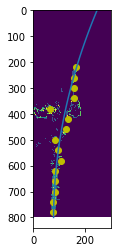

In [14]:
runner.run(image=warped_images[1])
left, right = split_image_lr( runner['mega_image'] )

target_cells = lane_cells(left, 30, 20)

target_cells_coords = lane_cells_real_coords(target_cells, left, 30, 20)
p_coefs = np.polyfit(target_cells_coords[:, 1], target_cells_coords[:, 0], 2)
poly_left = get_polynomial_2(p_coefs)

plt.imshow(left)
plt.plot(target_cells_coords[:, 0], target_cells_coords[:, 1], 'yo')

poly_y = np.linspace(0, left.shape[0])
poly_x = poly_left(poly_y)
plt.plot(poly_x, poly_y)

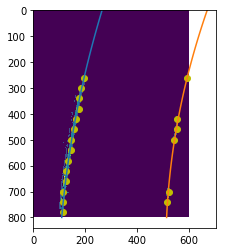

In [15]:
runner.run(image=warped_images[4])
left, right = split_image_lr( runner['mega_image'] )

target_cells_left = lane_cells(left, 30, 20)
target_cells_coords_left = lane_cells_real_coords(target_cells_left, left, 30, 20)
p_coefs_left = np.polyfit(target_cells_coords_left[:, 1], target_cells_coords_left[:, 0], 2)

target_cells_right = lane_cells(right, 30, 20)
target_cells_coords_right = lane_cells_real_coords(target_cells_right, right, 30, 20)
target_cells_coords_right[:, 0] += left.shape[1]
p_coefs_right = np.polyfit(target_cells_coords_right[:, 1], target_cells_coords_right[:, 0], 2)

# PLOTTING

poly_left = get_polynomial_2(p_coefs_left)
poly_right = get_polynomial_2(p_coefs_right)

plt.imshow( runner['mega_image'] )
plt.plot(target_cells_coords_left[:, 0], target_cells_coords_left[:, 1], 'yo')
plt.plot(target_cells_coords_right[:, 0], target_cells_coords_right[:, 1], 'yo')

poly_y = np.linspace(0, runner['mega_image'].shape[0])
plt.plot(poly_left(poly_y), poly_y)
plt.plot(poly_right(poly_y), poly_y)